## Visual search with k-NN

The idea here is to implement a little search engine based on the high-level image
representation and k-nearest neighbors
- Fit and tune a k-NN classifier 
- Pick an image from the test set and plot its 10 nearest neighbors from the train set with the tuned k-NN model

In [35]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
with np.load('train.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_train = npz_file['features']
    y_train = npz_file['targets']

In [3]:
with np.load('valid.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_valid = npz_file['features']
    y_valid = npz_file['targets']

In [4]:
with np.load('test.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_test = npz_file['features']
    y_test = npz_file['targets']

In [5]:
# X = np.concatenate((x_train, x_valid, x_test), axis=0)
# y = np.concatenate((y_train, y_valid, y_test), axis=0)

In [6]:
print('X:', x_train.shape, x_train.dtype)
print('y:', y_train.shape, y_train.dtype)

X: (280, 1280) float32
y: (280,) int32


In [7]:
import pandas as pd

In [8]:
# The categories correspond to digits from 0 and 5
pd.value_counts(y_train, normalize=True)

0    0.235714
1    0.228571
2    0.182143
4    0.150000
3    0.114286
5    0.089286
dtype: float64

There is NOT the same proportion of images for each class (bike: 23%, van: 8%)

Again, the data has already been standardized during the feature extraction process.It's possible to standardize the data with TensorFlow, but especially in the case of
images, this might not be what you want. Dividing by 255 should be enough to do the
necessary preprocessing here.

----

- Fit and tune a k-NN classifier

you are supposed to do a simple grid search with a static split (one single for loop where you change $k$)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [10]:
# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=5, # Set k to 5
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm='brute'
)

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([
    ('knn', knn)
])
knn_pipe.fit(x_train, y_train)

# Evaluate on test set
accuracy = knn_pipe.score(x_valid, y_valid)

# Print accuracy
print('k-nearest neighbors (k=5) accuracy: {:.3f}'.format(accuracy))

k-nearest neighbors (k=5) accuracy: 0.252


In [11]:
# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=5)]
k_values

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [12]:
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:

    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(x_train, y_train)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'k': k,
        'train_accuracy': knn_pipe.score(x_train, y_train),
        'valid_accuracy': knn_pipe.score(x_valid, y_valid),
        'test_accuracy': knn_pipe.score(x_test, y_test)
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='valid_accuracy', ascending=False).head()

,k,test_accuracy,train_accuracy,valid_accuracy
8,40,0.46,0.317857,0.446043
14,70,0.44,0.271429,0.431655
16,80,0.38,0.282143,0.417266
15,75,0.42,0.275000,0.417266
7,35,0.42,0.339286,0.417266


The optimal k values seems to be between 40 and 50. To get a better overview, let's plot the validation curves:

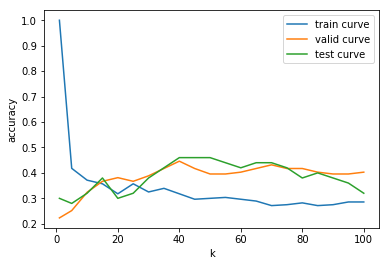

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results['k'], gs_results['train_accuracy'], label='train curve')
plt.plot(gs_results['k'], gs_results['valid_accuracy'], label='valid curve')
plt.plot(gs_results['k'], gs_results['test_accuracy'], label='test curve')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

The test accuracy seems to stabilize for k between 40 and 50 in the results from above. Let's see if we can get better results by averaging the scores over 30 runs for k between 40 and 50.

In [14]:
k_values = np.arange(40, 51, step=1)
k_values

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [15]:
gs_results = []
for run_idx in range(30):

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(x_train, y_train)

        # Save model and its performance on train/test sets
        gs_results.append({
            'k': k,
            'run_idx': run_idx,
            'train_accuracy': knn_pipe.score(x_train, y_train),
            'valid_accuracy': knn_pipe.score(x_valid, y_valid)
        })
        
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

In [16]:
# Group results by alpha value
grouped = gs_results.groupby('k')

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.valid_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.valid_accuracy.std()

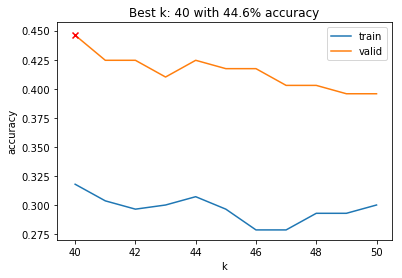

In [17]:
# Plot mean scores
plt.plot(k_values, mean_tr, label='train')
plt.plot(k_values, mean_te, label='valid')

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker='x', c='red', zorder=10)
plt.fill_between(k_values, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te-std_te, mean_te+std_te, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_te[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

-----

- Pick an image from the test set and plot its 10 nearest neighbors from the train set with the tuned k-NN model

In [18]:
tuned_knn_pipe = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=40)) 
])

tuned_knn_pipe.fit(x_train, y_train) # Fit to train set
tuned_knn_pipe.score(x_test, y_test) # Report performance


0.46

In [19]:
image_nb = knn.kneighbors(x_test, n_neighbors=10)
image_nb

(array([[11.519711 , 11.963047 , 12.159569 , 12.739821 , 12.990003 ,
         13.021393 , 13.12276  , 13.245563 , 13.303754 , 13.6478   ],
        [11.560115 , 12.264443 , 12.725573 , 12.984441 , 13.205996 ,
         13.532917 , 13.543681 , 13.699183 , 13.780868 , 13.780927 ],
        [15.271844 , 15.30598  , 15.535749 , 15.547529 , 15.563168 ,
         15.984039 , 16.022924 , 16.115858 , 16.210299 , 16.537638 ],
        [16.926847 , 17.338726 , 17.364847 , 17.396002 , 17.480392 ,
         17.548447 , 18.02356  , 18.124224 , 18.261938 , 18.393364 ],
        [11.678423 , 12.013836 , 12.709884 , 13.085426 , 13.489153 ,
         13.642934 , 14.016154 , 14.057353 , 14.198546 , 14.648166 ],
        [15.693138 , 16.495455 , 17.268839 , 17.76603  , 17.878769 ,
         17.992243 , 18.189104 , 18.260424 , 18.322348 , 18.478653 ],
        [11.473242 , 11.819454 , 13.521769 , 13.668375 , 15.018533 ,
         15.036057 , 15.194439 , 15.309803 , 15.349116 , 15.39339  ],
        [14.259589 , 15.382

Test image: first picture of the test data (= 'bike-0100')

In [40]:
generator = ImageDataGenerator(rescale=1/255)

In [41]:
testset = generator.flow_from_directory(
     'test', batch_size=3, target_size=(224, 224))

Found 50 images belonging to 6 classes.


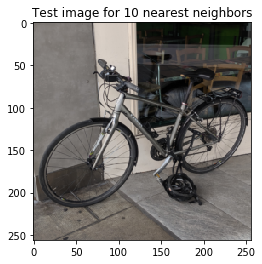

In [43]:
img = Image.open('test\\' + testset.filenames[0])
img_resized = img.resize([224, 224], resample=Image.BILINEAR) # Expected size
img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255

plt.title('Test image for 10 nearest neighbors')
plt.imshow(img)
plt.show()

10 nearest neighbors of the test image in the train data:

In [22]:
image_nb[1][0]

array([ 47, 261, 276, 171,  80,  22,  48,  17,  40,  19], dtype=int64)

In [38]:
trainset = generator.flow_from_directory(
     'train', batch_size=3, target_size=(224, 224))

Found 280 images belonging to 6 classes.


In [71]:
img_set = []


for i in image_nb[1][0]:
    img = Image.open('train\\' + trainset.filenames[i])
    img_set.append(img)

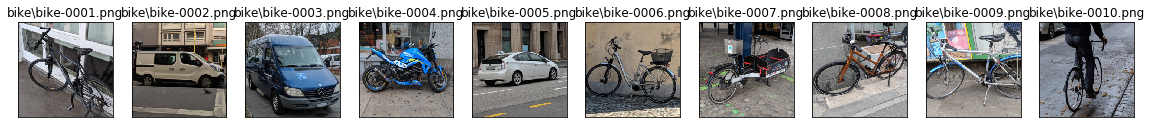

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 10))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
            
    # contain each axis and its index in the list of axes
    # img = Image.open('test\\' + testset.filenames[i])

    # Plot array
    axis.imshow(img_set[i]) # Grayscale (reversed)
    axis.set_title(trainset.filenames[i])
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

----------

Store the model name and the accuracy on the test data in a .csv file:

In [27]:
knn_pipe.score(x_test, y_test)

0.46

In [28]:
Test_accuracy_03_Visual_search_with_k_NN =  pd.DataFrame(data = {'model': ['k-NN'], 'test_acurracy': [knn_pipe.score(x_test, y_test)]})

In [29]:
Test_accuracy_03_Visual_search_with_k_NN.to_csv(path_or_buf = r'C:\Users\heyus\Desktop\Desktop\EPFL_Data Science COS\EPFL\04. Applied Machine Learning 2\11. Course project\Test_accuracy_03_Visual_search_with_k_NN.csv')